# Задачи к Лекции 7

Дана база данных рукописаного текста MNIST (только цифры). Данная база состоит из 70000 объектов, каждый из которых представлен изображением 28x28 пикселей и имеющих метку от 0 до 9.

**Чтение данных**

In [1]:
%matplotlib inline
import zipfile
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml

# https://www.openml.org/d/554
# Это займет умеренно существенно время, пока данные скачаются
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)


In [2]:
# немного уменьшим данные (опционально)
#X = X[:10000]
#y = y[:10000]

**Получение различной информации**

In [3]:
X.shape
X = X.astype(int)
X

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [4]:
y.shape

(70000,)

In [5]:
y[0]

'5'

In [6]:
# преобразуем метки в числа
#list(map(int, y))
Y = list(map(int, y))
Y = np.array(Y)
Y

array([5, 0, 4, ..., 4, 5, 6])

Проверим, что наглая обрезка данных выше не попортила баланс целевых исходов.

In [7]:
np.unique(Y, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([6903, 7877, 6990, 7141, 6824, 6313, 6876, 7293, 6825, 6958],
       dtype=int64))

Убедимся, что это и правда числа

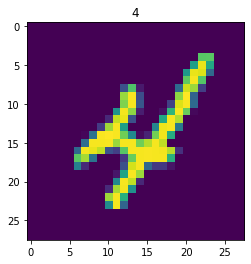

In [8]:
n = 9

plt.imshow(X[n].reshape((28, 28)))
plt.title("%d" % Y[n])
plt.show()

Попробуем наивное обучение с помощью kNN

In [9]:
from sklearn.model_selection import train_test_split

train, test, target_train, target_test = train_test_split(X, Y, shuffle=False)

In [10]:
train.shape, test.shape

((52500, 784), (17500, 784))

In [11]:
%%time 

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

knn = KNeighborsClassifier(3)
# Это будет довольно долго
knn.fit(train, target_train)

Wall time: 25.8 s


KNeighborsClassifier(n_neighbors=3)

In [ ]:
%%time 

# Это будет очень долго
predict = knn.predict(test)

In [ ]:
accuracy_score(target_test, predict)

**1. Выбрать любой из классификаторов градиентного бустинга, представленного в лекции (SKLearn, XGBoost, LightGBM, CatBoost). Подобрать их гиперпараметры так, чтобы получить наименьшую ошибку доли правильных ответов (accuracy_score). Для этого необходимо самостоятельно изучить соответствующие классификаторы и их гиперпараметры.**

In [ ]:
X_small = X[:10000]
y_small = Y[:10000]

#pd_y_small = pd.DataFrame(y_small, columns = ["class"])

#y_small_oh = pd.get_dummies(pd_y_small["class"],prefix="class")


X_train, X_test, y_train, y_test = train_test_split(X_small, 
                                                    y_small,
                                                    test_size=0.3, 
                                                    shuffle=False)

print(y_test.dtype)
print(np.unique(y_small, return_counts=True))
print(X_small.shape)
print(y_small.shape)

In [ ]:
%%time
import xgboost as xgb

parameters = {
    'max_depth': np.linspace(1, 10, 1),    # глубина дерева
    'learning_rate': np.linspace(0, 0.9, 10), # процент выборки для обучения 
    'n_estimators': np.linspace(500, 5000, 25), # регуляризация
    'booster' : ['gbtree', 'gblinear', 'dart']
    
}

clf = xgb.XGBClassifier(parameters)

clf.fit(X_train, y_train)
predict = clf.predict(X_test)
print(accuracy_score(y_test, predict))


In [ ]:
clf_xgb = xgb.XGBClassifier(parameters)
results = cross_val_score(clf_xgb, 
                          X_train, 
                          y_train,
                          n_jobs=-1)


results

In [ ]:
params = {
    'max_depth': np.linspace(1, 10, 1),    # глубина дерева
    'learning_rate': np.linspace(0, 0.9, 10), # процент выборки для обучения 
    'n_estimators': np.linspace(500, 5000, 25), # регуляризация
    'booster' : ['gbtree', 'gblinear', 'dart']  
}


clf_xgb = xgb.XGBClassifier()
xgb_GridS_CV = GridSearchCV(clf_xgb,
                            params, 
                            scoring="accuracy", 
                            cv=5,
                            n_jobs=-1)

xgb_GridS_CV.fit(X_train, y_train)
#pred = xgb_GridS_CV.predict(X_test)
print(xgb_GridS_CV.best_params_)

**Комментарии:**

In [ ]:
%%time
import lightgbm as lgbm
from sklearn.model_selection import GridSearchCV

parameters = {
    'max_depth': np.arange(1, 10, 2),    # глубина дерева
    'learning_rate': np.arange(0, 1, 0.2), 
    'n_estimators': np.arange(50, 200, 25),
    'boosting_type' : [ 'gbdt', 'dart', 'goss', 'rf' ]
}


clf = lgbm.LGBMClassifier()

gcv = GridSearchCV(clf, parameters, refit = True, 
                   n_jobs = -1, cv = 5, scoring = "accuracy")

#rcv = RandomizedSearchCV(clf, parameters, n_iter=50, scoring="accuracy", cv=2, refit = True)
#
#rcv.fit(train, target_train)
gcv.fit(train, target_train)
print(gcv.best_params_)
print(gcv.best_score_)